In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.segmentation import clear_border
from skimage.filters import try_all_threshold, threshold_otsu, threshold_li, threshold_yen
from skimage.color import label2rgb
from skimage import measure
import pandas as pd

In [2]:
def plot_results(image, threshold, name, show_plots=True, save_plots=False):
    # Remove spheroids that are touching the image boarders
    clear_image = clear_border(image > threshold)
    
    # Find interconnected pixels that form a spheroid
    label_image = measure.label(clear_image)
    label_image_rgb = label2rgb(label_image)
    
    # Plotting
    if show_plots:
        plt.figure(figsize=(16,4), dpi=300)
        plt.subplot(131)
        plt.imshow(image, cmap='jet')
        plt.title(name)

        plt.subplot(132)
        bins = 50
        hist = np.histogram(image.flatten(), bins=bins, range=(0,255))
        plt.bar(hist[1][1:]-255/bins/2, hist[0], width=4)
        plt.yscale('log')
        ticks=np.arange(0,255,20)
        plt.xticks(ticks=ticks, labels=ticks)
        plt.plot([threshold, threshold], [0,hist[0].max()*0.9], c='r', label='Threhshold = {:3d}'.format(threshold))
        plt.title('Intensity histogram for threshold adjustment')
        plt.legend()

        plt.subplot(133)
        plt.imshow(label_image_rgb)
        plt.title('Segmented spheroids by color')
        if save_plots:
            plt.savefig(path_out+name)
        plt.show()
        
    return label_image

def calculate_area(label_image, name, min_diameter=10):
    # Calculate spheroid size
    props = measure.regionprops_table(label_image, image, properties=['label', 'equivalent_diameter', 'area'])
    df = pd.DataFrame(props)
    df = df[df['equivalent_diameter']>min_diameter].reset_index()
    df['index'] = name
    df['label'] = np.arange(df.shape[0]) + 1
    
    print('Found number of blobs: ', df.shape[0], '\n')
    return df

# Load images

In [3]:
# Provide path for the folder with jpg images
path = 'img_in/'
path_out = 'img_out/'
if not os.path.exists(path_out):
    os.makedirs(path_out)
    
file_names = [x for x in os.listdir(path) if x.endswith('.jpg')]
df_all = pd.DataFrame()

# Load images
images = []
for file_name in file_names:
    image = 255-plt.imread(path+file_name)[:,:,0] # reverse intensity and select only 1st intensity channel from jpg
    images.append(image)
plt.show()

# Analyze images individually 

Threshold Li:  63


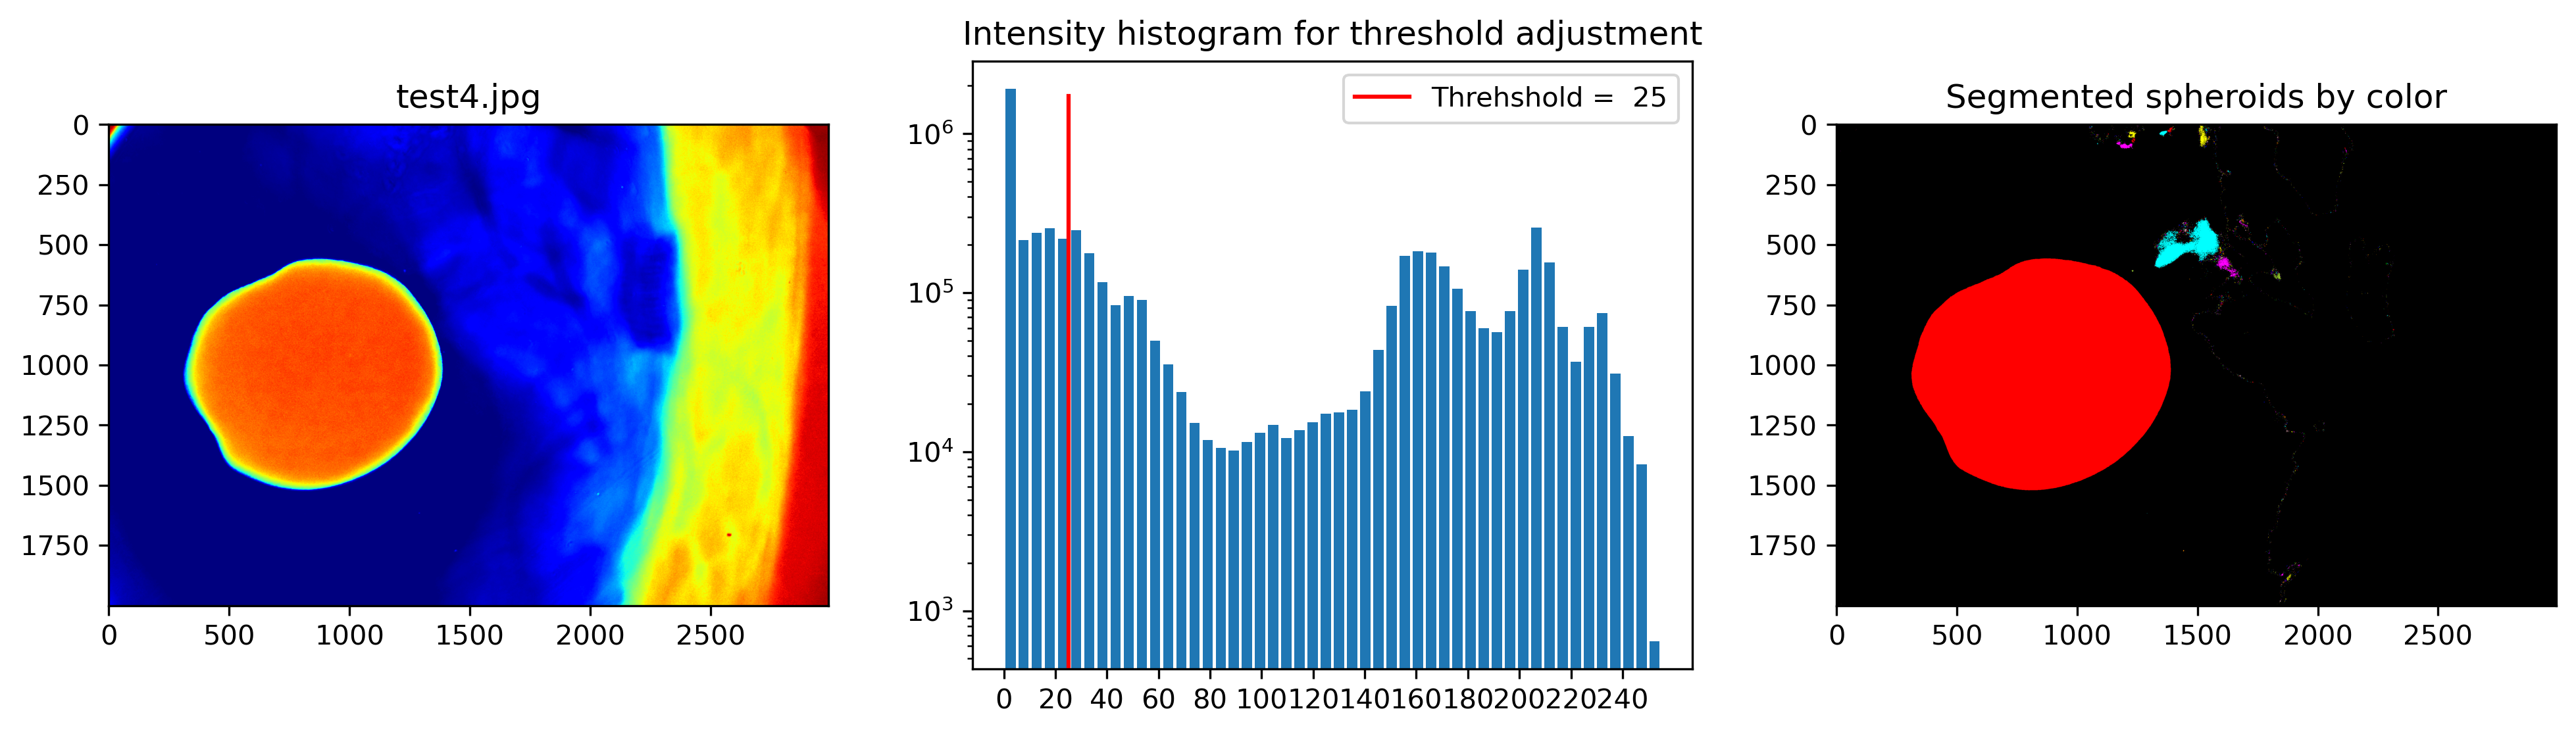

In [4]:
image_number = 0
image = images[image_number]
# Automated threshould calculation
# Cross-entopy thresholding, usually the best for background identification
threshold_auto = np.round(threshold_li(image, initial_guess=30)).astype('int') 
print('Threshold Li: ', threshold_auto)

# Manualy selected threshold based on image analysis results (histogram and segmented spheroid)
# or when it needs to be fixed to keep experimenal results comparable 
# assuming the camera settings are the same
threshold_manual = 25

# Investigate images and if happy - proceed next or adjust the threshold
label_image = plot_results(image, threshold = threshold_manual, name=file_names[image_number], show_plots=True)

In [5]:
# Calculate area of the blobs
# and exclude false blobs that are too small (noise)
df_tmp = calculate_area(label_image, name=file_names[image_number], min_diameter=40)
df_tmp

Found number of blobs:  4 



,index,label,equivalent_diameter,area
0,test4.jpg,1,42.550519,1422.0
1,test4.jpg,2,172.645700,23410.0
2,test4.jpg,3,53.189644,2222.0
3,test4.jpg,4,1002.039456,788605.0


# Merge results

In [6]:
if df_all.empty:
    df_all = df_tmp
else:
    df_all = pd.concat([df_all, df_tmp], ignore_index=True)
df_all

,index,label,equivalent_diameter,area
0,test4.jpg,1,42.550519,1422.0
1,test4.jpg,2,172.645700,23410.0
2,test4.jpg,3,53.189644,2222.0
3,test4.jpg,4,1002.039456,788605.0


# Export results

In [7]:
# Save to Excel
df_all.to_excel("output.xlsx")

# Run through all images 

Analysing file:  test4.jpg
Threshold Li:  63


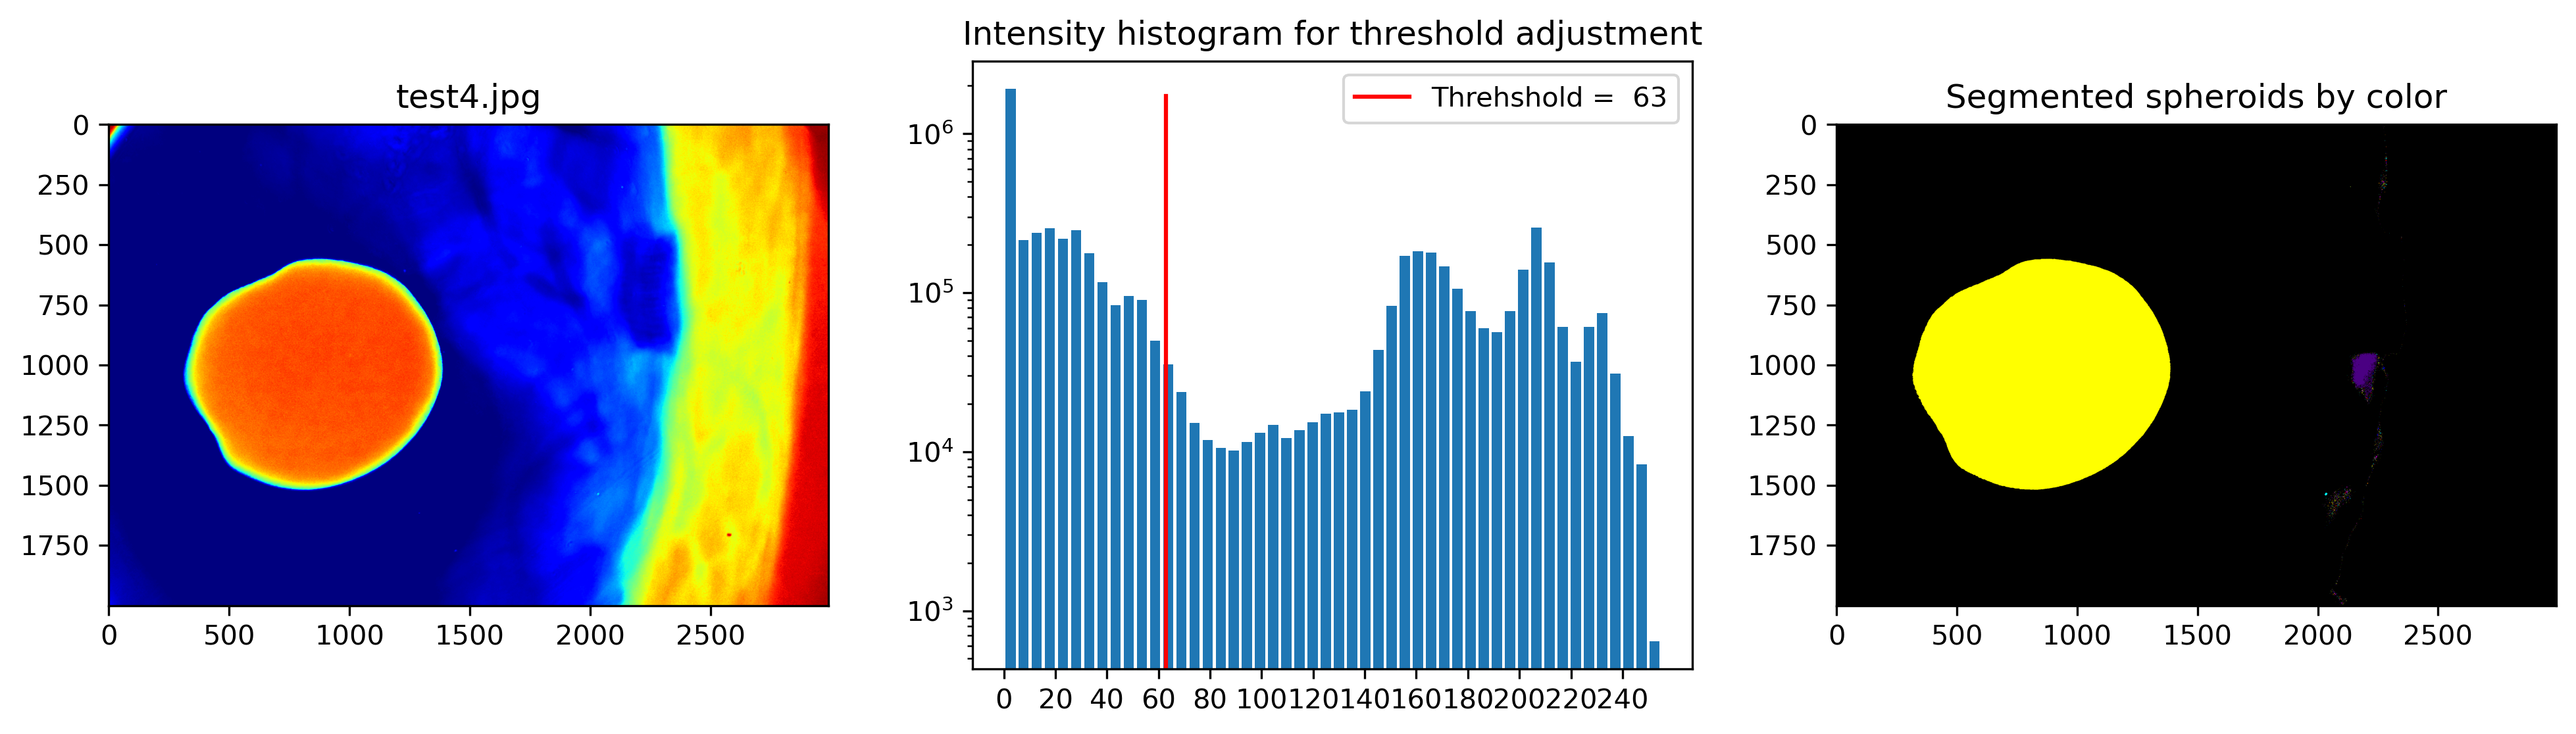

Found number of blobs:  2 

Analysing file:  test1.jpg
Threshold Li:  31


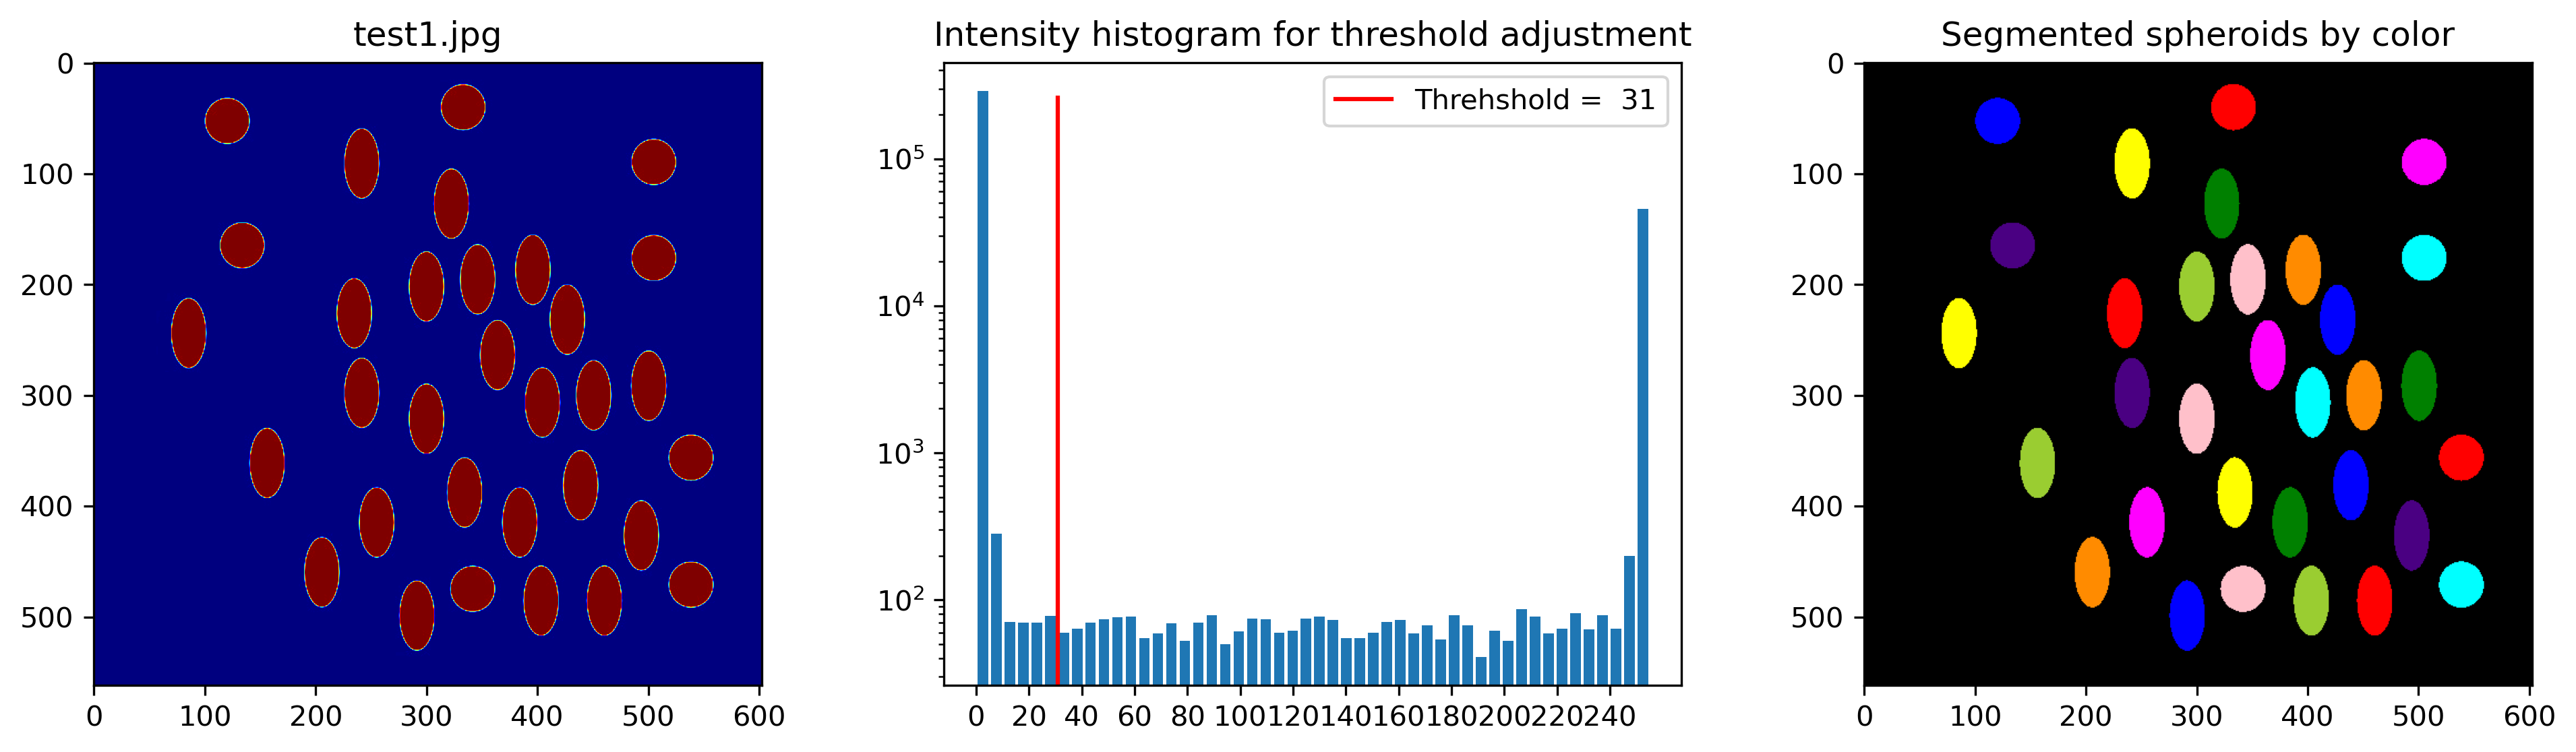

Found number of blobs:  32 

Analysing file:  test3.jpg
Threshold Li:  26


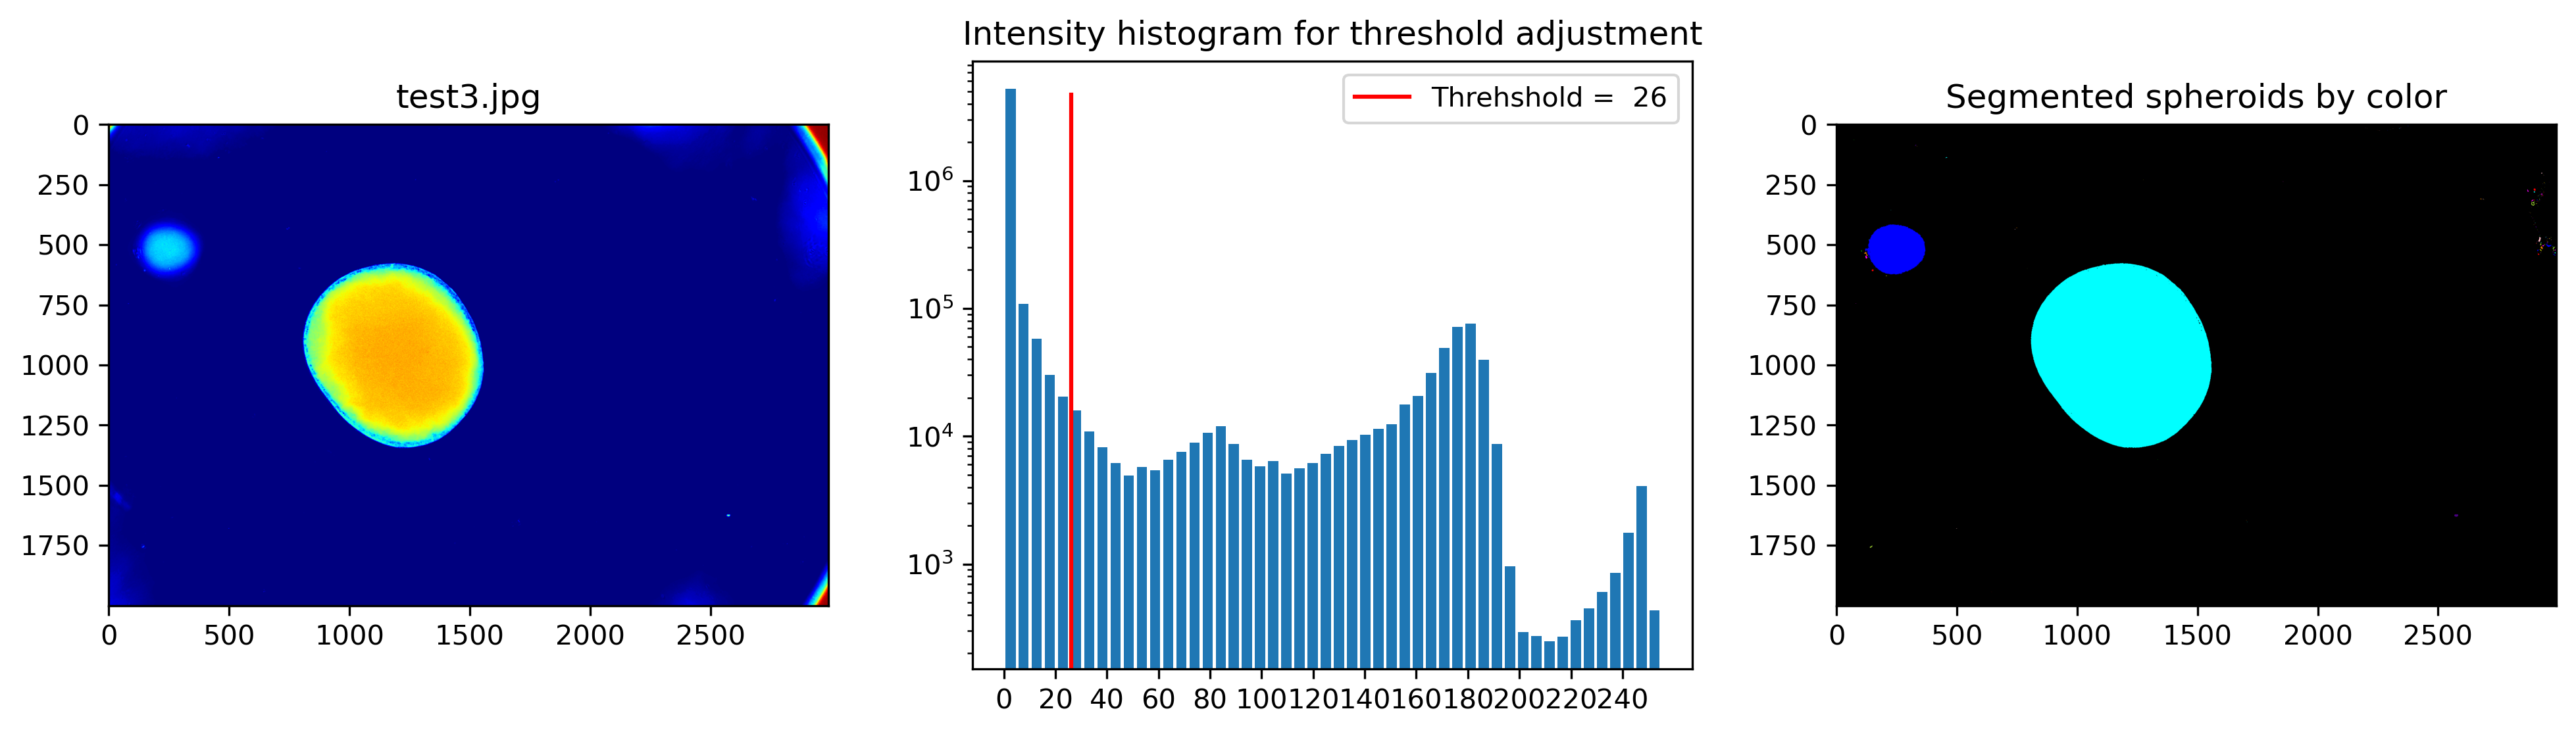

Found number of blobs:  2 

Analysing file:  test2.jpg
Threshold Li:  18


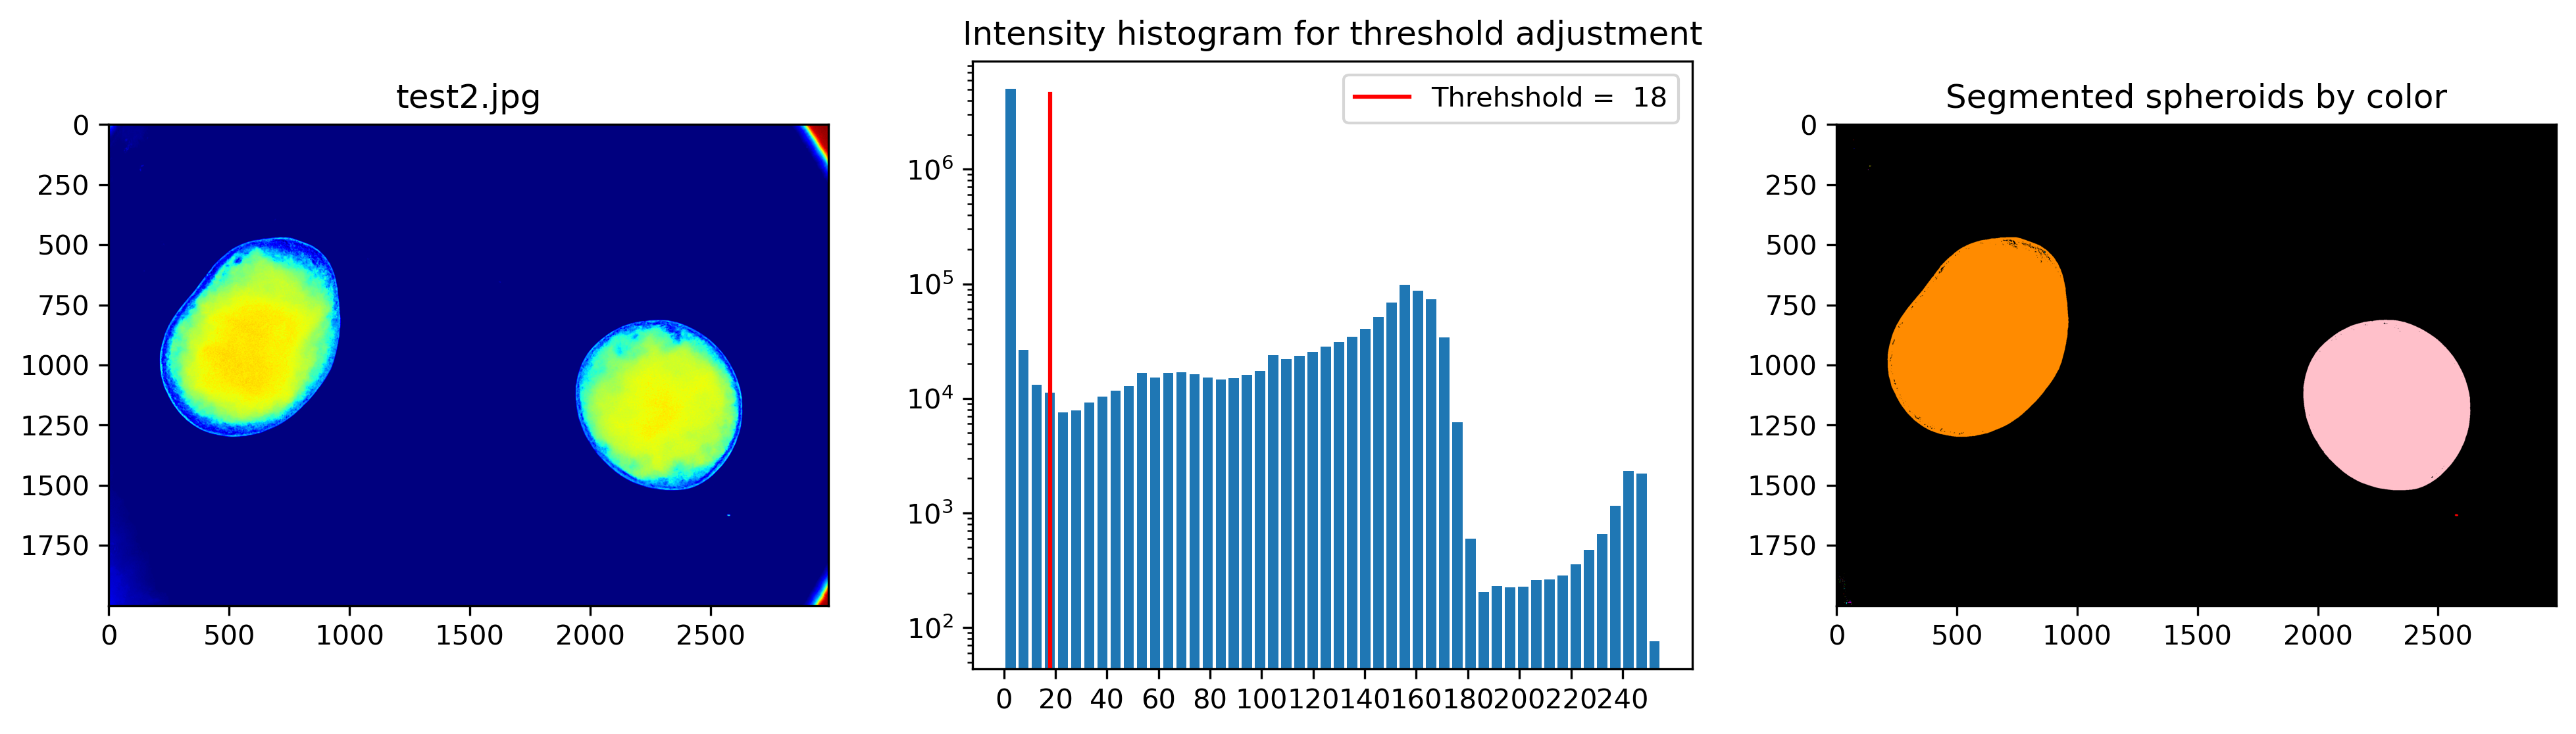

Found number of blobs:  2 

        index  label  equivalent_diameter      area
0   test4.jpg      1           996.896014  780530.0
1   test4.jpg      2           115.668497   10508.0
2   test1.jpg      1            40.949438    1317.0
3   test1.jpg      2            40.996051    1320.0
4   test1.jpg      3            44.979747    1589.0
5   test1.jpg      4            40.949438    1317.0
6   test1.jpg      5            44.837989    1579.0
7   test1.jpg      6            40.933889    1316.0
8   test1.jpg      7            44.993898    1590.0
9   test1.jpg      8            40.980519    1319.0
10  test1.jpg      9            44.993898    1590.0
11  test1.jpg     10            44.951431    1587.0
12  test1.jpg     11            44.908924    1584.0
13  test1.jpg     12            45.050459    1594.0
14  test1.jpg     13            44.951431    1587.0
15  test1.jpg     14            44.965591    1588.0
16  test1.jpg     15            45.121060    1599.0
17  test1.jpg     16            44.9

In [8]:
N_images = len(images)
analyse_images = range(N_images)

for i, image_number in enumerate(analyse_images):
    print('Analysing file: ', file_names[image_number])
    image = images[image_number]
    # Automated threshould calculation
    # Cross-entopy thresholding, usually the best for background identification
    threshold_auto = np.round(threshold_li(image, initial_guess=30)).astype('int') 
    print('Threshold Li: ', threshold_auto)

    # Manualy selected threshold based on image analysis results (histogram and segmented spheroid)
    # or when it needs to be fixed to keep experimenal results comparable 
    # assuming the camera settings are the same
    threshold_manual = 25

    # Investigate images
    label_image = plot_results(image, threshold = threshold_auto, name=file_names[image_number], show_plots=True, save_plots=True)

    # Calculate area of the blobs
    # and exclude false blobs that are too small (noise)
    df_tmp = calculate_area(label_image, name=file_names[image_number], min_diameter=40)
    
    if i == 0:
        df_all = df_tmp
    else:
        df_all = pd.concat([df_all, df_tmp], ignore_index=True)
    
print(df_all)


# Export results

In [9]:
# Save to Excel
df_all.to_excel("output_all.xlsx")